<a href="https://colab.research.google.com/github/nkharlamova/ML/blob/main/!!HW_13_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TASK: Practice forecasting using Prophet.**

**Dataset: https://fred.stlouisfed.org/series/T10Y2Y**

In [ ]:
pip install u8darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.6/819.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
pip install u8darts[all]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 41.6 MB/s eta 0:00:00


In [ ]:
pip install u8darts[prophet]

In [ ]:
import pandas as pd
import numpy as np

from io import StringIO

import requests

from darts import TimeSeries
from darts.models import ARIMA
from darts.models import ExponentialSmoothing
from darts.models import Prophet
from darts.metrics import mae

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt

**Loading the dataset.**

In [ ]:
# Завантажуємо датасет
url = "https://fred.stlouisfed.org/data/T10Y2Y.txt"
response = requests.get(url)
data = response.text
column_names = ["Date", "Value"]
df = pd.read_csv(StringIO(data), sep='\s+', skiprows=19, usecols=[0, 1], names=column_names, header=None)

In [ ]:
df.head()

,Date,Value
0,1976-06-01,0.68
1,1976-06-02,0.71
2,1976-06-03,0.70
3,1976-06-04,0.77
4,1976-06-07,0.79


**Let's take a look at the information regarding the columns.**

In [ ]:
# Дивимось інформацію по колонках
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12444 entries, 0 to 12443
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    12444 non-null  object
 1   Value   12444 non-null  object
dtypes: object(2)
memory usage: 194.6+ KB


**Columns are in the form of objects. We have to convert the column 'Date' to datetime type.**

In [ ]:
# Колонки у вигляді об'єктів
# Перетворюємо колонку Date в тип datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

**Converting the column 'Value' into numerical format.**

In [ ]:
# Переводимо колонку Value в числовий формат
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")

**Transforming the 'Date' column into an index.**

In [ ]:
# Перетворюємо колонку Date в індекс
df.set_index("Date", inplace=True)

**Let's check for any NaN values.**

In [ ]:
# Перевіримо, чи є значення nan
nan_count = df.isna().sum()
print(nan_count)

Value    523
dtype: int64


**There are quite a few of them, so instead of deleting them, let's fill them with the previous values.**

In [ ]:
# Їх досить багато, тож не будемо видаляти, а заповнимо попередніми значеннями
df_cleaned = df.fillna(method="ffill")

**Building the ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) graphs.**

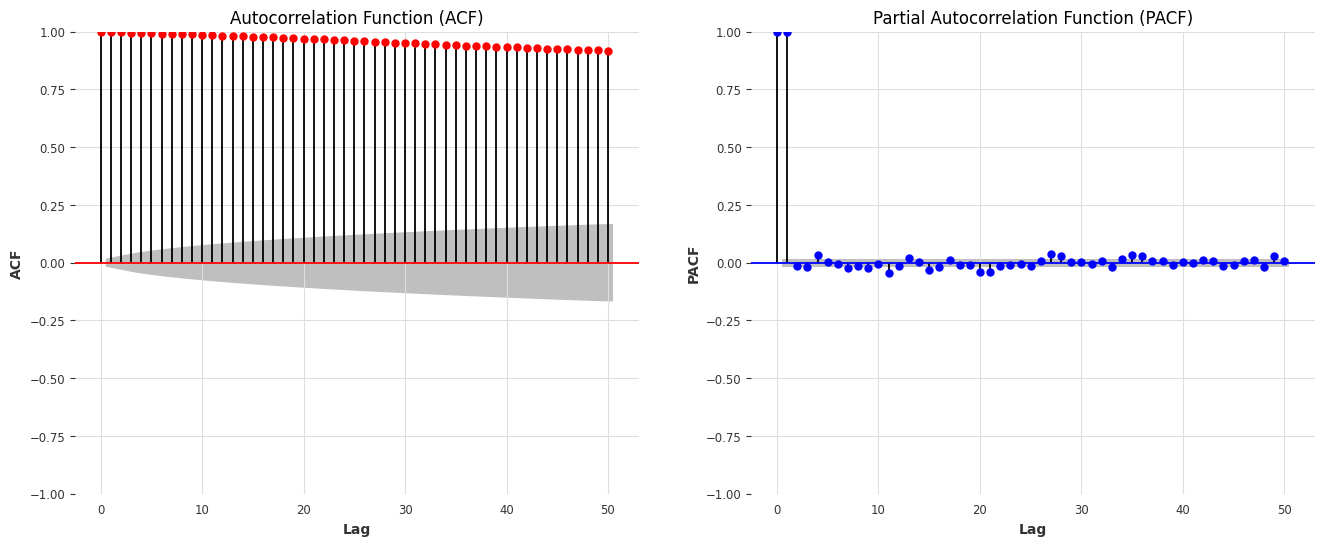

In [ ]:
# Будуємо графіки ACF та PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Графік ACF
sm.graphics.tsa.plot_acf(df_cleaned["Value"], lags=50, alpha=0.05, ax=axes[0], color="red")
axes[0].set_title("Autocorrelation Function (ACF)")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("ACF")

# Графік PACF
sm.graphics.tsa.plot_pacf(df_cleaned["Value"], lags=50, alpha=0.05, ax=axes[1], color="blue")
axes[1].set_title("Partial Autocorrelation Function (PACF)")
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("PACF")

plt.show()

**We have very high autocorrelation. So we will apply smoothing techniques.**

In [ ]:
# Маємо дуже високу автокореляцію, будемо згладжувати

**Transforming the data into a TimeSeries object.**

In [ ]:
# Перетворюємо дані в об'єкт TimeSeries
series = TimeSeries.from_dataframe(df_cleaned, time_col=None, value_cols="Value")

**Smoothing the data by changing the frequency of the time series.**

In [ ]:
# Згладжуємо дані, змінивши частоту часового ряду
series = series.resample("M").mean()

**Let's see what we've got.**

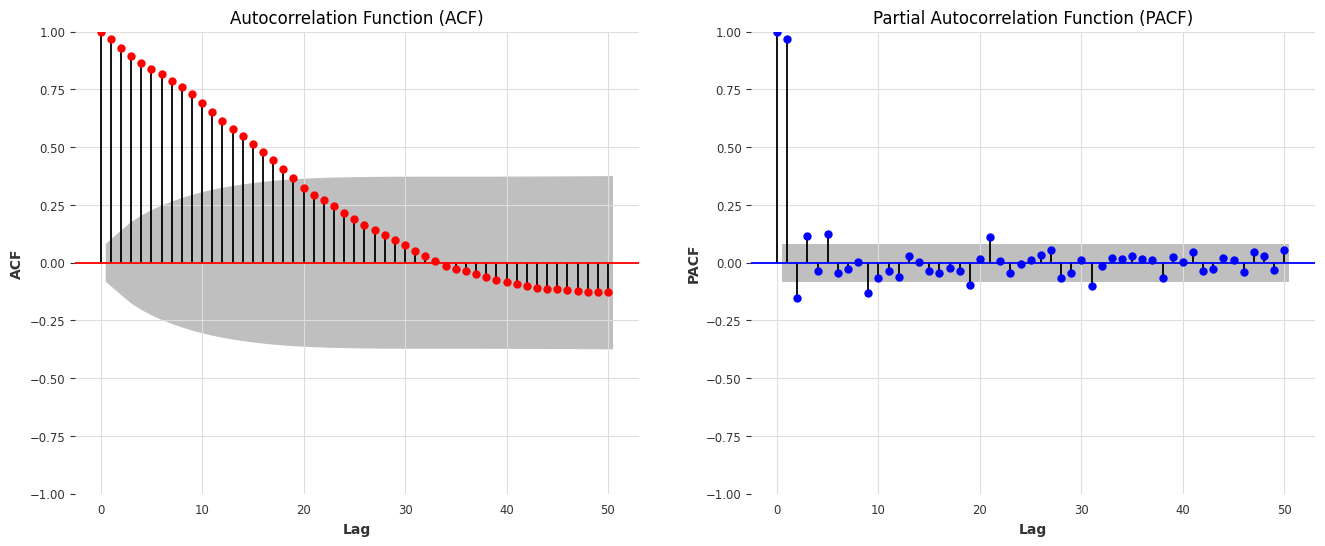

In [ ]:
# Подивимось що вийшло

# transforming the TimeSeries object into a dataset:
# Перетворюємо об'єкт TimeSeries в датасет
df_series = series.pd_dataframe()

# Building the ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) graphs:
# Будуємо графіки ACF та PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Графік ACF
sm.graphics.tsa.plot_acf(df_series["Value"], lags=50, alpha=0.05, ax=axes[0], color="red")
axes[0].set_title("Autocorrelation Function (ACF)")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("ACF")

# Графік PACF
sm.graphics.tsa.plot_pacf(df_series["Value"], lags=50, alpha=0.05, ax=axes[1], color="blue")
axes[1].set_title("Partial Autocorrelation Function (PACF)")
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("PACF")

plt.show()

**It seems better, though not perfect. Let's continue trying to tune the parameters for the ARIMA model.**

In [ ]:
# Виглядає краще, хоч і не ідеально. Спробуємо далі попідбирати параметри до моделі ARIMA

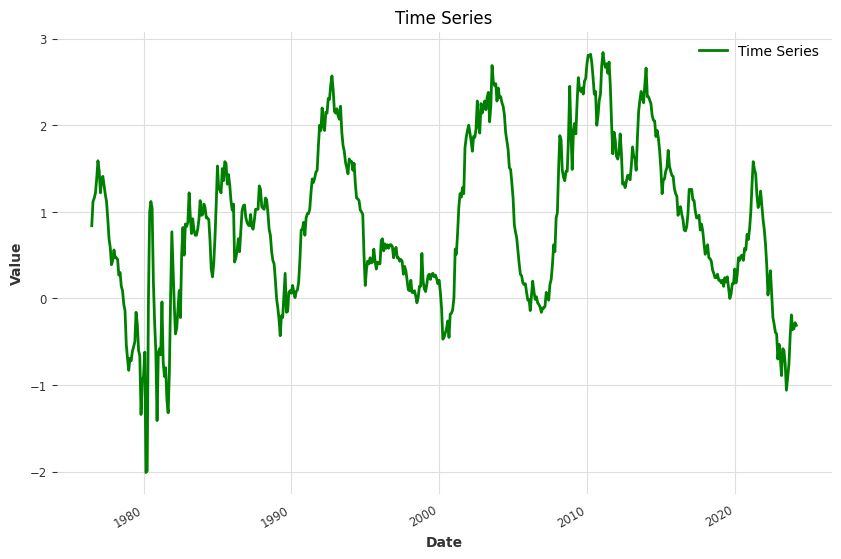

In [ ]:
# building the time series graph:
# Будуємо графік часового ряду
plt.figure(figsize=(10, 6))
series.plot(label="Time Series", color="green")
plt.title("Time Series")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()

plt.show()

**The values are unevenly distributed, and there doesn't seem to be any particular pattern on the graph. We can observe a significant decline around 2008, likely due to the global financial crisis, and another decline around 2019, possibly influenced by the coronavirus pandemic. Further, there is another decline in 2022 (due to war), but after that, it gradually begins to rise again. Overall, we see that the conditions for sharp increases or decreases are not predictable.**

In [ ]:
# Значення розподілені не рівномірно, на графіку не відслідковується якоїсь особливої логіки.
# Можна побачити великий спад в районі 2008 року, що скоріш за все пов'язано з всесвітньою кризою,
# також спад в районі 2019 - напевно вплив коронавіруса. Далі знову спад 2022 (війна), але після цього потроху починає зростати.
# Загалом, бачимо, що умови різких зростаннь/спадів не такі, що можна спрогнозувати

**Splitting the dataset into training and test samples.**

In [ ]:
# Розділяємо дані на тренувальну та тестову частини
train, val = series.split_after(pd.Timestamp("2019-01-01"))

**Let's start with the ARIMA model.**

In [ ]:
# Почнемо з моделі ARIMA
model = ARIMA(p=4, d=0, q=1)
model.fit(train)
forecast = model.predict(len(val), num_samples=100)

**Display the forecast and actual data.**

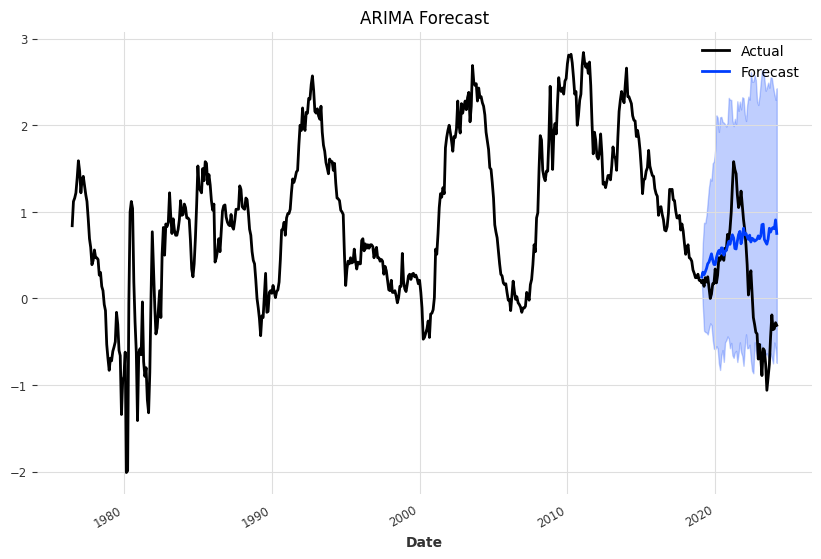

In [ ]:
# Виводимо форкаст і фактичні дані
plt.figure(figsize=(10, 6))
series.plot(label="Actual")
forecast.plot(label="Forecast", lw=2)
plt.title("ARIMA Forecast")
plt.legend()

plt.show()

**So the forecast closely matches the actual data around 2019-2021, but after that we can see a relatively stable upward trend, whereas in reality, there is a significant decline.**

In [ ]:
# Отже прогноз має схожість з фактичними даними в районі 2019-2021 років, але далі бачимо більш-менш стабільний графік на підйом,
# в той час як в реальності спостерігаємо значний спад

**Let's try the Exponential Smoothing model.**

In [ ]:
# Спробуємо тепер модель ExponentialSmoothing
model_es = ExponentialSmoothing(seasonal_periods=12)
model_es.fit(train)
forecast_es = model_es.predict(len(val), num_samples=100)

**Let's see what we've got.**

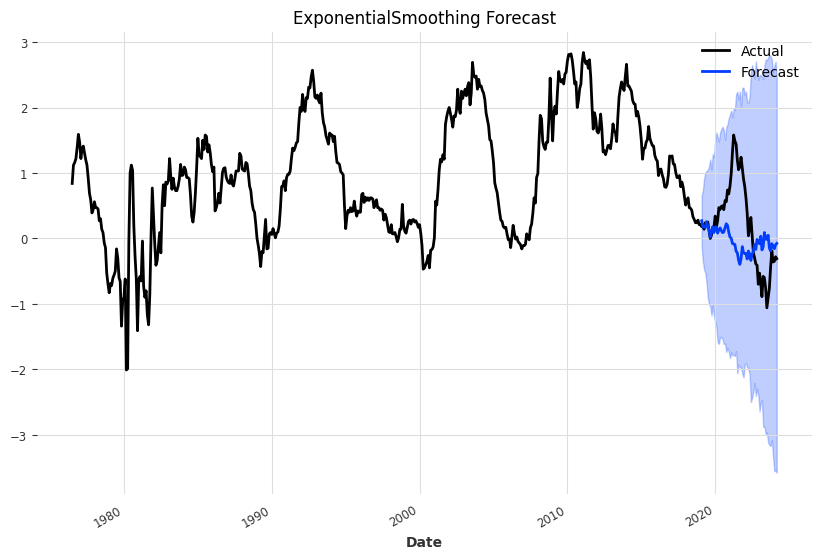

In [ ]:
# Дивимось що вийшло
plt.figure(figsize=(10, 6))
series.plot(label="Actual")
forecast_es.plot(label="Forecast", lw=2)
plt.title("ExponentialSmoothing Forecast")
plt.legend()

plt.show()

**Here the situation is slightly different. We see a downward trend, although not as strong as in the actual data.**

In [ ]:
# Тут ситуація трохи інша, бачимо тенденцію на спад, хоча і не такий сильний як на фактичних даних

**Let's try the Prophet model.**

In [ ]:
# Спробуємо модель Prophet
model_p = Prophet(
    seasonality_mode="multiplicative",
    seasonality_prior_scale=0.05,
    changepoint_prior_scale=0.5,
    uncertainty_samples=100,
)
model_p.fit(train)
forecast_p = model_p.predict(len(val))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3ya28a7g/mwo062m_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3ya28a7g/8479g9ky.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59748', 'data', 'file=/tmp/tmp3ya28a7g/mwo062m_.json', 'init=/tmp/tmp3ya28a7g/8479g9ky.json', 'output', 'file=/tmp/tmp3ya28a7g/prophet_modelb1ca3gsy/prophet_model-20240212162956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:29:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:29:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


**Let's see what we've got.**

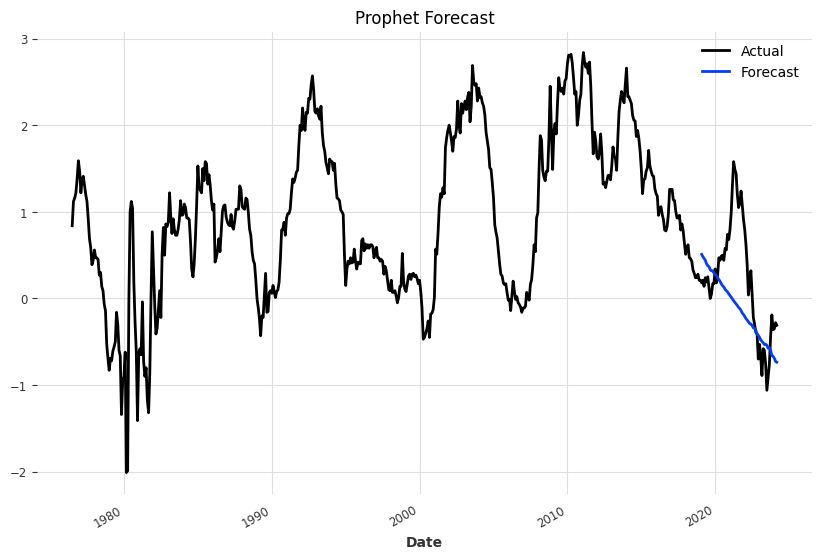

In [ ]:
# Дивимось що вийшло
plt.figure(figsize=(10, 6))
series.plot(label="Actual")
forecast_p.plot(label="Forecast", lw=2)
plt.title("Prophet Forecast")
plt.legend()

plt.show()

**So, Prophet provided a curve with a sharp decline.**

In [ ]:
# Отже, Prophet дав криву з різким спадом.

**Let's take a look at the performance of the models.**

In [ ]:
# Подивимось ще на продуктивність моделей
mae_score_a = mae(val, forecast)
mae_score_es = mae(val, forecast_es)
mae_score_p = mae(val, forecast_p)

print("MAE ARIMA:", mae_score_a)
print("MAE ExponentialSmoothing:", mae_score_es)
print("MAE Prophet:", mae_score_p)

MAE ARIMA: 0.6096171234116391
MAE ExponentialSmoothing: 0.5483528598230382
MAE Prophet: 0.49202282706843997


**Prophet yielded the best result, but we understand that a 49% mean absolute error is still quite high. ARIMA provided the worst forecast, although over a longer time period, this model has shown to be the best performer. Overall, we conclude that depending on the model and its parameters, we get vastly different forecasts.**

In [ ]:
# Найкращий результат дав Prophet, але розуміємо, що 49% середньої абсолютної помилки це все ж забагато.
# Найгірший прогноз дала ARIMA,
# хоча при взятті більшого часового відрізка ця модель була навпаки найкраща.

# Загалом робимо висновок, що в залежності від моделі і її параметрів маємо абсолютно різні прогнози.